***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)    
    * Previous: [5.3 Gridding and Degridding for using the FFT](5_3_gridding_and_degridding.ipynb)
    * Next: [5.5 The Break Down of the Small Angle Approximation and the W-Term](5_5_widefield_effect.ipynb)

***

Import standard modules:

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import section specific modules:

In [15]:
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import HBox
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

In [3]:
from IPython.display import HTML, Javascript
HTML('../style/code_toggle.html')

***

## 5.4 脏图与可见度权重 The Dirty Image and Visibility Weightings <a id='imaging:sec:weights'></a>

我们已经讲了空域滤波器、采样和点扩散函数、针对快速傅立叶变换的网格化，接下来，我们将把这些概念联系起来，看看如何应用这些知识去处理得到一张射电干涉测量的观测图像。观测得到的所谓“脏“图（称之为脏图，是为了跟后面一章去卷积的内容相对应）可以近似表达为：

Now that we have laid out the concepts of spatial filters, sampling and point spread functions, and gridding for using fast Fourier transforms, we are ready to connect all this topics into one to show how an image is produced from a radio interferomtric array observation. The so called 'dirty' image (the reason for this term relates to the deconvolution stage which is covered in the next chapter) from an observation is approximately

$$ I^{\textrm{D}}(l,m) \approx \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} S(u,v) \, V_{\textrm{obs}}(u,v) \, e^{-2\pi i(ul+vm)} \,du\,dv $$

$V_{\textrm{obs}}(u,v)$表示观测可见度，这是uv域的一个完整连续测量，事实上，我们从来都得不到真正的$V_{\textrm{obs}}(u,v)$。$S(u,v)$是采样函数，主要由基线轨迹的uv覆盖构成。这是一个近似表达，因为我们采用[van Cittert-Zernike Theorem &#10142;](../4_Visibility_Space/4_5_The_Fourier_Approximation_VanCittert-Zernike_Theorem.ipynb) 把3-D公式降到了2-D，下节内容我们将探讨这种近似的局限以及如何进行‘w-term’修正。

where $V_{\textrm{obs}}(u,v)$ is the observated visibilities, this function is a complete, continuous measurement of the uv domain, which in reality is never measured because $S(u,v)$ is the sampling function, the main component of which is the uv coverage of the baseline tracks. This is an approximate result as we have used [van Cittert-Zernike Theorem &#10142;](../4_Visibility_Space/4_5_The_Fourier_Approximation_VanCittert-Zernike_Theorem.ipynb) approximation to reduce the complete 3-D visibility equation to 2-D. The limits to this approximation and how to correct for the 'w-term' is covered in the next section.

采样函数$S$，正如我们在前一节网格化内容中所所见过的那样，包括uv轨迹采样和网格化操作。本章后面我们还会看到，采样函数会被泛化，各种权重函数也将被算到采样函数中。通常用$ V^{\textrm{S}}$表示采样可见度

The sampling function $S$, as we have seen in the previous section on gridding, contains the uv track sampling and the gridding operator. And, as we will see later in this chapter, the sampling function will be generalized to include various 'weighting' functions. It is often useful to talk of the sampled visibilities

$$ V^{\textrm{S}} = S(u,v) \, V_{\textrm{obs}}(u,v) $$

这是把来自所有基线的可见度样本组合到单个可见度平面上。对比一下 [5.1 &#10142;](5_1_spatial_frequencies.ipynb)节中的2-D傅立叶变换的脏图公式，我们可以看出，所谓的脏图，就是采样可见度的一个简单傅立叶变换。

which is combination of the visibility samples from all baselines onto a single visibility-space plane. Comparing the dirty image equation to that of the 2-D Fourier transform in Section [5.1 &#10142;](5_1_spatial_frequencies.ipynb) we see that the dirty image is simply the Fourier transform of the sampled visibilities.

$$ I^{\textrm{D}} = \mathscr{F}\{V^{\textrm{S}}\} = \mathscr{F}\{ S V_{\textrm{obs}}\}$$

简洁起见，这里抛弃了$(l,m)$ 和 $(u,v)$。根据傅立叶理论([$\S$ 2.5 &#10142;](../2_Mathematical_Groundwork/2_5_convolution.ipynb))，脏图可以解释为两个函数的卷积。

The $(l,m)$ and $(u,v)$ notation has been dropped here for compactness. By Fourier theory ([$\S$ 2.5 &#10142;](../2_Mathematical_Groundwork/2_5_convolution.ipynb)) the dirty image can be interpreted as a convolution of two functions. 

$$ I^{\textrm{D}} = \mathscr{F}\{ S \} \circ \mathscr{F}\{ V_{\textrm{obs}}\}$$

正如我们在[5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb)节所看到的那样，第一个函数$\mathscr{F}\{ S \}$是阵列的PSF响应，跟阵列配置、天空位置、观测时间，以及频率覆盖有关。第二个函数$\mathscr{F}\{ V_{\textrm{obs}}\}$是全采样可见度空间的傅立叶变换。虽然我们不可能得到$V_{\textrm{obs}}$，但是下一章[next chapter &#10142;](../6_Deconvolution/6_0_introduction.ipynb)我们将看到，我们可以通过PSF去卷积，得到一个$V_{\textrm{obs}}$的近似重建。我们可以把$\mathscr{F}\{ V_{\textrm{obs}}\}$看成是来自可见度平面全采样重建得到的理想图$I^{\textrm{ideal}}$，重新一下上面的脏图公式，把脏图表示成阵列PSF和理想图的卷积。

As we have seen in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb) the first function $\mathscr{F}\{ S \}$ is the PSF response of the array, which we have seen is dependent on the array configuration, sky poisiton, observation time, and frequency coverage. The second function $\mathscr{F}\{ V_{\textrm{obs}}\}$ is the Fourier transform of the fully sampled visibility space. We never has access to $V_{\textrm{obs}}$, but as we will see in the [next chapter &#10142;](../6_Deconvolution/6_0_introduction.ipynb), we include *a priori* information to make an approximate reconstruction of $V_{\textrm{obs}}$ via deconvolution of the PSF. We can think of $\mathscr{F}\{ V_{\textrm{obs}}\}$ being the ideal image $I^{\textrm{ideal}}$ reconstructed from fulling sampling the visibility plane. Re-writing the equation above the dirty image is the convolution of the array PSF with the ideal image.

$$ I^{\textrm{D}} = \textrm{PSF} \circ I^{\textrm{ideal}}$$

回到本章早先的例子，我们使用KAT-7的一次观测的PSF响应[5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb)，从原始的鸭子图生成脏图。

Returning to examples from earlier in the chapter we can construct a dirty image from the original duck image and the KAT-7 PSF response from one of the observations in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb).

In [4]:
duck = mpimg.imread('figures/Anas_platyrhynchos_male_female_quadrat_512.png')

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b #standard grayscale conversion
    return gray

gDuck = rgb2gray(duck)
fftDuck = np.fft.fft2(gDuck) #take the Fourier transform of the image to poduce the observed visibilities

In [5]:
hdulist = fits.open('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_100chans_natural-psf.fits')
psf = hdulist[0].data #shape [polarization, channel, m, l]
sampFunc = np.fft.fft2(psf[0,0]) #take the Fourier transform of the PSF to generate the gridded sampling function

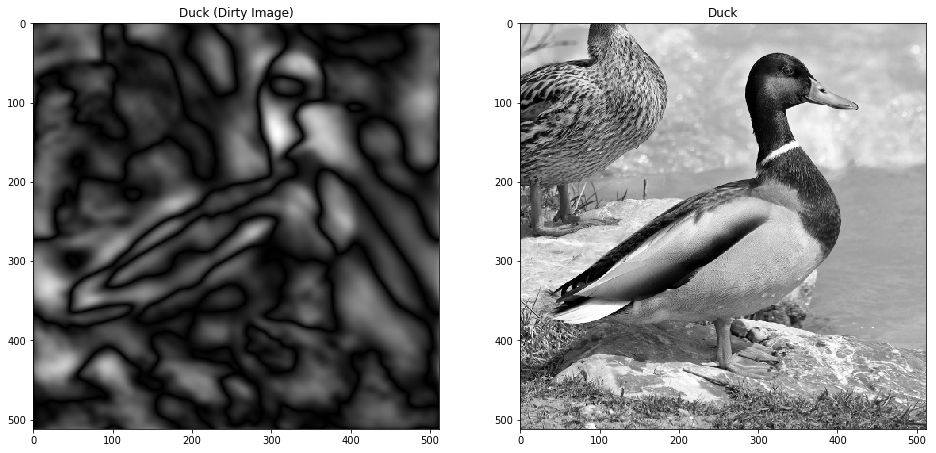

In [6]:
fig, axes = plt.subplots(figsize=(16,8))

ax1 = plt.subplot(1,2,1)
fftDirtyImg = sampFunc * fftDuck #multiplication in Fourier space is equivalent to convolution in image space
dirtyImg = np.abs(np.fft.fftshift(np.fft.ifft2(fftDirtyImg))) #create the dirty image
plt.title('Duck (Dirty Image)')
imgPlot0 = plt.imshow(dirtyImg)
imgPlot0.set_cmap('gray')

ax2 = plt.subplot(1,2,2)
plt.title('Duck')
imgPlot1 = plt.imshow(gDuck)
imgPlot1.set_cmap('gray')

图：鸭子的脏图（左），鸭子的原始图（右），采用KAT-7的100个频率通道，6小时，赤纬-30度的观测采样。

*Figure: dirty image of a duck (left) created by sampling the original duck image (right) with a KAT-7 observation using 100 frequency channels, over a 6 hour observation at declination -30 degrees.*

所成的脏图中，难以分辨出鸭子。因为我们已经知道了原图的样子，所以还能指认出鸭头和和鸭翅膀。如果事先不知道原图，要说出图的内容还是很困难的。这正是干涉测量成像的主要问题，需要我们持续不断研究去卷积算法加以解决。

It is hard to make out the duck in the resulting dirty image. The head and long wing can be picked out, but that is likely due to the fact that we know what the original image looked like. Had we not known what the original image was we would have a difficult time deciding what we are seeing. This is the main issue in interferometric imaging, and has perpetuated the development of deconvolution algorithms.

绘出的点扩散的傅立叶变换跟 [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb)所看到的uv覆盖图类似，事实确是如此，不过要注意色条所给出的像素值范围。到目前为止，我们隐藏了一些细节，以便于简单展示出采样函数及其对成图的影响。接下来，我们将在采样函数中引入权重函数。

Plotting the Fourier transform of the PSF should result in a similar image of the uv coverage plot seen in Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb). Indeed it does, but notice that the color bar suggests a range of pixel values. This comes back to the overlapping uv tracks we saw in the uv coverage plots and the type of weighting scheme which was used to produce the PSF. We have been hiding a few details up until this point to simplify the presentation of sampling functions and how they affect resulting images. But, now we will generalize sampling function to introduce weighting functions.

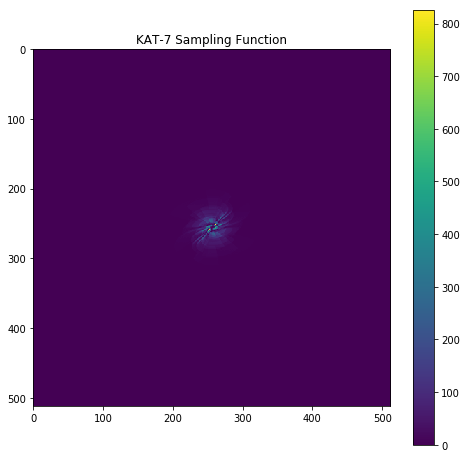

In [7]:
fig = plt.figure(figsize=(8,8))
plt.title('KAT-7 Sampling Function')
imgPlot = plt.imshow(np.abs(np.fft.fftshift(sampFunc)))
plt.colorbar()

图：KAT-7的采样函数，100个通道，观测时长6小时，-30度赤纬。

*Figure: KAT-7 sampling function for an observation using 100 frequency channels, over a 6 hour observation at declination -30 degrees.*

### 5.4.1 加权函数，泛化的采样函数 Weighting Functions, a generalization of sampling functions

如[5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb)中KAT-7的例子，采样函数由多个基线轨迹构成，相应的可见度域存在空白和重叠采样。到目前位置，我们所讨论的采样函数都是二值，即有测量的位置，值为1，没有测量的位置，值为0。把0值赋给未被测量到的位置应该是有道理的，因为没有测量就没有信息，所以相应的像素可能为任何值。然而，对于有测量值的位置，其采样函数值则不一定都为1。例如，假设某次观测，一共测量了1000个uv点，其中100个点测了10次，900个点只测了1次。测了10次的这100个点，其灵敏度为其它900个点的$\sqrt{10}$倍，因此在成图的时候，由于测量准确度更高，应该给予更高的权重；同时，观测阵列由不同望远镜构成，其中某些基线灵敏度会高于另外一些基线，如VLBI，在成图的时候，高灵敏度基线的测量值应当给予更高的权重；对于某些科学研究，其研究兴趣主要集中在特定空间频率范围，需要把点源从大规模气体结构中分离出来。在上述情况下，都需要我们对采样函数进行调整，在成图的时候，需要考虑更多的因素。事实上，在从可见度生成图像的时候，并没有一系列的标准选项，权重函数也总是要事前给出。密度权重函数是在成图过程中，我们必须要给出的最为常见的权重函数，当然，我们也会讨论波束锥度和可信度权重。

The sampling function, as seen in the Section [5.2 &#10142;](5_2_sampling_functions_and_psfs.ipynb) KAT-7 examples, are made up of the various baseline tracks which leads to holes and overlapping sampling of the visibility domain. So far we have discussed sampling functions as if they are binary functions, a visibility domain pixel is given a value of 1 if a baseline track measured that location otherwise the pixel was given a value of 0. The allocation of 0 to each pixel which was not measured should make sense, as there is no information, and thus that pixel can potentially have any value. But, for the measured pixels the sampling function value does not necessarily need to be 1. For example, say an observation results in 1000 uv positions being measured, and 100 of these positions were measured 10 times while the other 900 positions were only measured once. The 100 positions measured 10 times, will have a $\sqrt{10}$ improvement in sensitivity compared to the other 900 positions, so perhaps those 100 spatial frequency modes should be given more weight in the resulting image because we are more sure about the accuracy of the measurement. Or, perhaps an array is made up of many different types of telescopes which leads to some baselines having a higher sensitivity to other baselines, such as in VLBI. Or, perhaps the science case is only interested in certain spatial frequencies, such as seperating point sources from large-scale gas structure. These are all examples of times when we would like to adjust our sampling function, which leads to a number of different options we need to understand when creating an image. In fact, there is no standard set of options to create an image from visibilities, a weighting function must always be decided upon before hand. The most common weighting function we must decide on when imaging is the density weighting function, but we will also discuss the beam taper and reliability weighting.

为简化起见，在讨论过程中，我们一直把PSF看成是可见度采样函数的傅立叶对，事实上，广泛来看，我们需要把PSF看成是权重函数$W$的傅立叶对，其中$W$本身包括了采样函数。

As a simplification we have been discussing the PSF as being a Fourier pair of the visibility sampling function, but in fact we need to generalize to say that the PSF is a Fourier pair of a weighting function $W$, where $W$ includes the sampling function.

$$ \textrm{PSF}(l,m) \rightleftharpoons W(u,v)$$

进一步扩展$W$，可以看到，$W$由多个函数构成。本节，我们将使用[<cite data-cite='1999ASPC..180.....T'>Synthesis Imaging in Radio Astronomy II</cite> &#10548;](http://adsabs.harvard.edu/abs/1999ASPC..180.....T)第7讲的符号，紧凑起见，我们省略掉了$(u,v)$项。

Expanding $W$ we see that it is made up over a number of functions. For this section we will use the notation based on Lecture 7 of [<cite data-cite='1999ASPC..180.....T'>Synthesis Imaging in Radio Astronomy II</cite> &#10548;](http://adsabs.harvard.edu/abs/1999ASPC..180.....T). For compactness the $(u,v)$ terms have been dropped.

$$ W = R \cdot T \cdot D \cdot S $$

$W$是我们已经讨论过的采样函数$S$、密度权重函数$D$、可选的锥度权重函数$T$，以及基线依赖的可信度权重函数$R$之乘积。

$W$ is a product of the the sampling function $S$ which we have all ready discussed, a density weight function $D$, an optional taper weight function $T$, and a baseline-dependent reliability weight function $R$.

作为一个简单的例子，让我们看看几个1-D权重函数及其生成的PSF。该例子里，如果我们只对1-D函数的内部中间区域进行采样，则得到一个矩形框采样（左图中蓝色表示）。然而，我们还有其它更好的采样方式，比如，探测器的响应随着与零点的距离呈线性变化，因此，需要给采样加上权重，距离中心点越近，权重越大，距离中心点越远，权重越小，相应的，采样函数变成了三角权重函数（左图中绿色表示）。又或者，高斯权重函数（左图中红色表示）有可能更适合。除此以外，还有许多其它类型的权重函数可以用于采样。这些权重函数有不同的PSF响应（见右图）。矩形权重函数（蓝色）的PSF主瓣高，然而旁瓣也明显高于其它权重函数。一个域的平滑函数，在其傅立叶域里也平滑，很显然，矩形函数就不是一个平滑函数。高斯函数是一个平滑函数，但是采样范围（信号处理中的窗口）有限，所以有一个截止点。相比于框函数，截断高斯（红色）的PSF响应旁瓣较低主瓣较宽。三角函数也如此，可以看作是高斯函数的一个简单近似。

As a simple example let us look at some 1-D weight functions and the resulting PSFs. For this example lets say we sample the inner centre of a 1-D function. This results in a square or boxcar sampling, as seen in blue in the left-hand figure below. But, say we think some samples are 'better' than others. For example, our detector has a linear response based on the distance from the zero point. Then, we would like to weigh the samples accordingly, giving more weight to samples near the centre and less to the samples on the far edges. This results in a triangle weight function, as seen in green in the left-hand figure below. Or, perhaps a Gaussian weighting function, red in the left-hand figure below, is more appropriate. There are many types of potential weighting functions which all cover the same extent of the sample space. But, these weighting functions result in different PSF responses as seen in the right-hand figure. Using a boxcar weighting function (blue) results in the highest PSF primary lobe, but the sidelobes are significantly higher compared to other weighting functions. This relates to the idea that a smooth function in one domain is also a smooth function in its Fourier domain, and a boxcar function is not a smooth function. A Gaussian function is a smooth function, but the sampling extent (or window in signal processing terms) is finite, this means that there is a cut-off point. The PSF response of a truncated Gaussian (green) has a wider primary lobe but lower sidelobes compared to the boxcar function. As does the triangle function which can as a simple approximation to the Gaussian.

(0, 512)

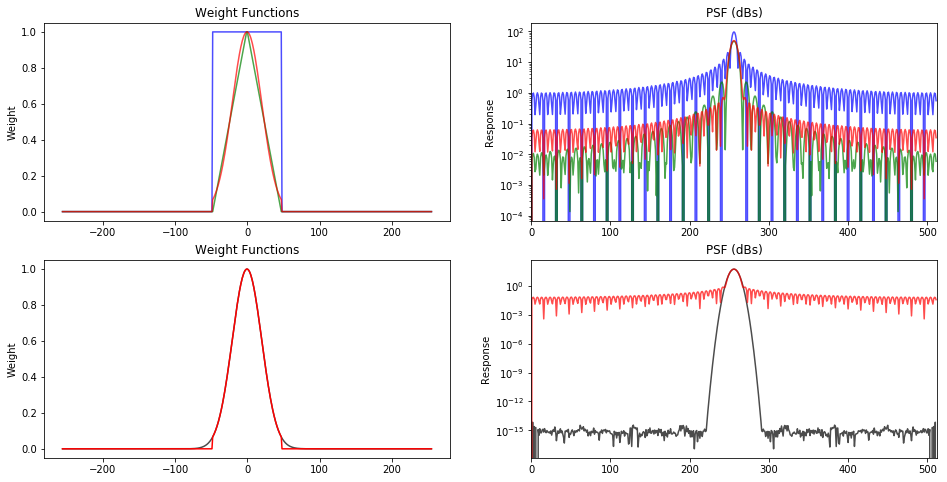

In [8]:
from scipy import signal

whw = 48 #window half width

#Square/Boxcar weight function
squareWeights = np.zeros(512, dtype='float')
squareWeights[256 - whw:256 + whw] = 1.

#Triangle weight function
triWeights = np.zeros(512, dtype='float')
triWeights[256 - whw : 256] = np.linspace(0., 1., num=whw)
triWeights[256 : 256 + whw] = np.linspace(1., 0., num=whw)

#Gaussian weight function
gaussWeights = signal.gaussian(512, std=whw / (2. * np.sqrt(2. * np.log(2.))))
truncGaussWeights = gaussWeights * squareWeights #truncate to window width

xVals = np.arange(-256,256)

fig, axes = plt.subplots(figsize=(16,8))
ax1 = plt.subplot(2,2,1)
plt.title('Weight Functions')
plt.ylabel('Weight')
plt.plot(xVals, squareWeights, 'b-', alpha=0.7)
plt.plot(xVals, triWeights, 'g-', alpha=0.7)
plt.plot(xVals, truncGaussWeights, 'r-', alpha=0.7)
#plt.plot(xVals, gaussWeights, 'k-', alpha=0.7)

ax1 = plt.subplot(2,2,2)
plt.title('PSF (dBs)')
plt.ylabel('Response')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(squareWeights))), 'b-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(triWeights))), 'g-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(truncGaussWeights))), 'r-', alpha=0.7)
#plt.plot(np.abs(np.fft.fftshift(np.fft.fft(gaussWeights))), 'k-', alpha=0.7)
ax1.set_yscale('log')
plt.xlim(0, 512)

ax1 = plt.subplot(2,2,3)
plt.title('Weight Functions')
plt.ylabel('Weight')
plt.plot(xVals, gaussWeights, 'k-', alpha=0.7)
plt.plot(xVals, truncGaussWeights, 'r-', alpha=1.0)

ax1 = plt.subplot(2,2,4)
plt.title('PSF (dBs)')
plt.ylabel('Response')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(gaussWeights))), 'k-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(truncGaussWeights))), 'r-', alpha=0.7)
ax1.set_yscale('log')
plt.xlim(0, 512)

上图：1-D的方形（蓝色）、三角形（绿色）、截断高斯（红色）权重函数，及其PSF响应。
下图：高斯（黑色）和截断高斯（红色）权重函数及其PSF响应，高斯响应中的微弱噪声归因于计算精度。

*Top: examples of 1-d weight functions: square (blue), triangle (green), truncated Gaussian (red) and the resulting PSF responses.*

*Bottom: Gaussian (black) and truncated Gaussian (red) weighting function and the resulting PSF responses. The low level 'noise' in the Gaussian response is due to computational accuracy limits.*

上图只画出了三种权重函数及其相应的PSF响应，没有一种函数是完美的，各有优缺点。矩形函数的的PSF主瓣强，但是旁瓣也高；三角函数旁瓣低，但是有信号损失和分辨率损失（与高斯函数一样）。分辨率损失（主瓣较宽）的原因在于给了距离中央较近的采样点更高的权重，而这些点所对应的正是低频部分。

The figure above shows just three possible weighting functions and the resulting PSF responses. There is no 'correct' function, each has advantages and disadvantages. A boxcar function maximizes the PSF primary lobe response but at the expense of high sidelobes. A triangle function minimizes sidelobes but at the expense of some loss in signal, and a loss of resolution (as does the Gaussian). This loss in resolution (that is a wider primary lobe) is because the weight function gives more value to the samples near the centre point, i.e. the lower spatial modes.

后面我们将看到，在合成图像的时候，我们会根据需求，是要强化分辨率，还是强化灵敏度，或者兼顾分辨率和灵敏度，来决定使用哪个权重函数。

As we will see, we can decide on a weighting function when synthesising an image to emphasize for resolution or sensitivity or a combination of the two in the density weighting funciton.

### 5.4.2 密度函数 Density Functions

在讨论、报告、论文中说到权重函数（或者策略）的时候，指的几乎总是“密度权重函数”。在一次观测中，密度权重函数根据每个uv点被采样的次数，来决定该uv点的权重，“uniform”和“natural”，即“统一”和“自然”权重，通常指的就是密度权重函数。

When discussion of weighting functions (or schemes) comes up in conversations, presentations, or papers it is almost always referring to *density weighting functions*. A density weighting function is used to set the weights of individual uv positions based on the number of times that position is sampled in an observation. One will often see terms such as 'uniform' and 'natural' weighting which are types of density weighting functions.

回到早先已经看过的KAT-7采样函数，我们发现其像素值在一个区间范围变化。原因在于，每次观测过程中，由于频率带宽覆盖和uv轨迹的重叠，一些点会被多次采样，在生成PSF响应的时候，我们给每次采样一个同等权重，这就导致了这些点的值属于一个区间范围。这一点跟上面讲到的1-D高斯权重采样类似。这种权重策略被称为“自然权重”（“natural weighting”，或者“variance weighting”），优点在于强化了灵敏度，代价是牺牲了分辨率。文献中经常提到，由于在低频部分的过度采样，自然权重会导致PSF主瓣的翼（“wings”）变宽。

Going back to the KAT-7 sampling function plot shown earlier, we see that the pixels range in values. That is, during the observation those pixels in the visibility domain were sampled multiple times due to a combination of the frequency bandwidth coverage and the uv track positions. In this case, when we formed the PSF response we decided to give each sample a equal weighting, this resulted in the pixels have a range of weights. This is similar to the Gaussian weighting function in the 1-d example above. This weighting scheme is called *natural weighting* (or inverse variance weighting), it has the advantage of maximizing sensitivity but at the cost of resolution. It is often stated in literature that natural weighting lead to broad 'wings' in the PSF primary lobe, this is due to the over representation of the low spatial frequency modes.

“统一权重”（“uniform weighting” or “unity weighting”）是另一种权重策略，该策略不管采样次数，平等对待每个采样点，给予相同权重。这有点类似于前面1-d采样例子中的矩形采样函数，以高PSF旁瓣为代价，获得更高分辨率的图像。

A complimentary weight scheme is *uniform weighting* (or unity weighting) which weights each sample positon equally, not matter how many times that position was sampled. This is akin to the boxcar weighting function in the 1-d example above, and results in a higher resolution image at the cost of higher PSF sidelobes.

正如[gridding section &#10142;](5_3_gridding_and_degridding.ipynb)所提到那样，要对采样到的可见度进行网格化，也就是把可见度放到像素点上，这些像素点构成一个2-d矩阵。对于没有采样的像素位置，其权重显然为0。某个位置只有一个采样，权重设置为1。然而，还存在一个像素位置对应多个采样，或者部分采样的情况。如果一个采样要被分配给多个像素，那么被分配到的这多个像素的总权重设置为1，例如，一次采样所获得的流量要分配给两个像素
$(p_a, p_b)$，其中$p_a$占60%，$p_b$占40%，则权重函数中，$p_a$为0.6，$p_b$为0.4。对于一个像素点被多次采样的情况，则权重被置为采样次数和。定义$N_s(u,v)$为某像素$(u,v)$点的采样次数，则自然权重函数可以表示为：


As covered in the [gridding section &#10142;](5_3_gridding_and_degridding.ipynb), when gridding the sampled visibilities are placed into pixels, that is a 2-D grid array. If no samples are placed in a pixel then that pixel obviously is given zero weight. For a given pixel, if only one sample is placed at that position then it would seem we could justify giving that pixel a weight of one. But, as we have seen, multiple samples, or 'portion' of samples can be placed in a single pixel. If a sample is split between multiple pixels the total allocated weight of the combined positions for that sample should equal one, e.g. if a pixel is split between two pixels $(p_a, p_b)$, with 60% of the flux belonging in $p_a$ and 40% in $p_b$ then the sample is given a weight of 0.6 in $p_a$ and 0.4 in $p_b$. For multiple samples, the weight is the sum of the number of samples. Thus, we define a function $N_s(u,v)$ which returns the number of samples for a given pixel $(u,v)$. A natural weighting function is

$$ D_{\textrm{natural}}(u,v) = N_s(u,v)$$

统一权重函数表示为：

and a uniform weighting function is

$$ D_{\textrm{uniform}}(u,v \, | \, t) = 
\begin{cases} 
    \hfill 1    \hfill & : N_s(u,v) > t  \\
    \hfill 0 \hfill & : N_s(u,v) \leq t \\
\end{cases}
$$

这里$t$是一个非负阈值参数，通常$t=0$。

where $t$ is a non-negative threshold parameter, usually $t = 0$.

使用哪种特定的权重策略取决于观测的科学目标。如果愿意牺牲灵敏度获得更高分辨率，你可以使用统一权重；如果观测的是暗弱源，愿意以分辨率为代价，则可以选择自然权重。下图给出了基于同一个天空模型，分别采用自然权重和统一权重所成的脏图。

When to use a specific weighting scheme depends on the scientific aim of the observation. If you are trying to maximize resolution and are willing to lose some sensitivty then you use uniform weighting. And, if you are observing a weak source and are willing to lose some resolution then you use natural weighting. In the figures below a dirty image is show for natural and uniform weighting based on the same sky.

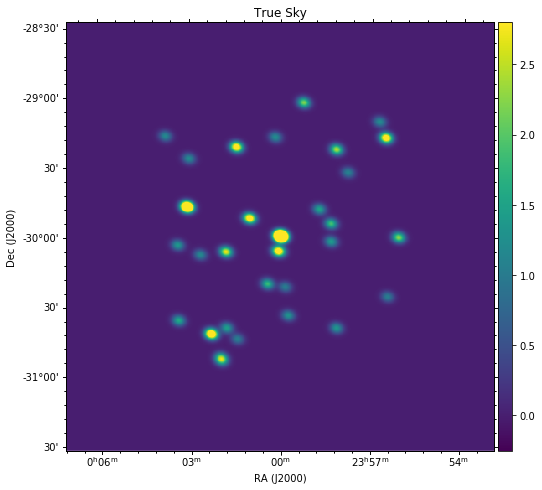

In [12]:
fig = plt.figure(figsize=(8, 8))

gc1 = aplpy.FITSFigure('../data/fits/true/KAT-7_6h60s_dec-30_10MHz_10chans_true.fits', figure=fig)
gc1.show_colorscale(cmap='viridis')
#gc1.show_colorscale(vmin=-2.5, vmax=5., cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('True Sky')
gc1.add_colorbar()

fig.canvas.draw()

图：模拟天空图。图中的每个源都是真实天空中的点源与一个2-D高斯进行卷积的结果。

*Figure: map of the simulated sky, each source has been convolved with a 2-D Gaussian in this figure but the real sky is made up of point sources.*

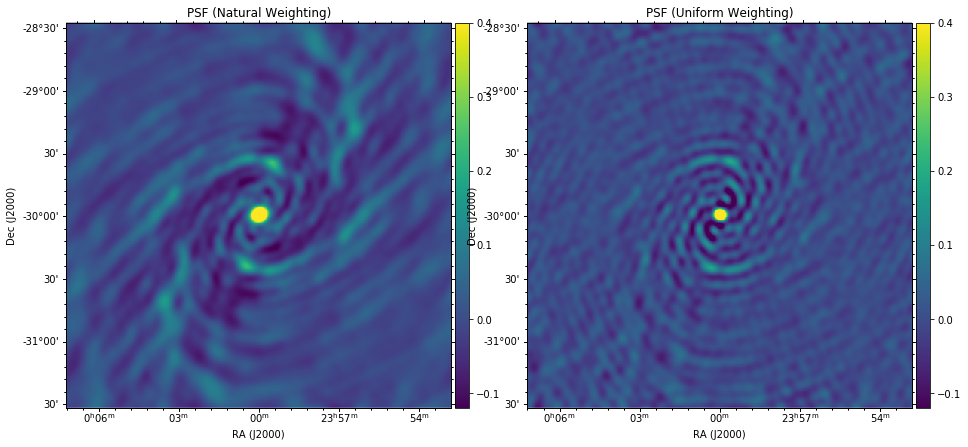

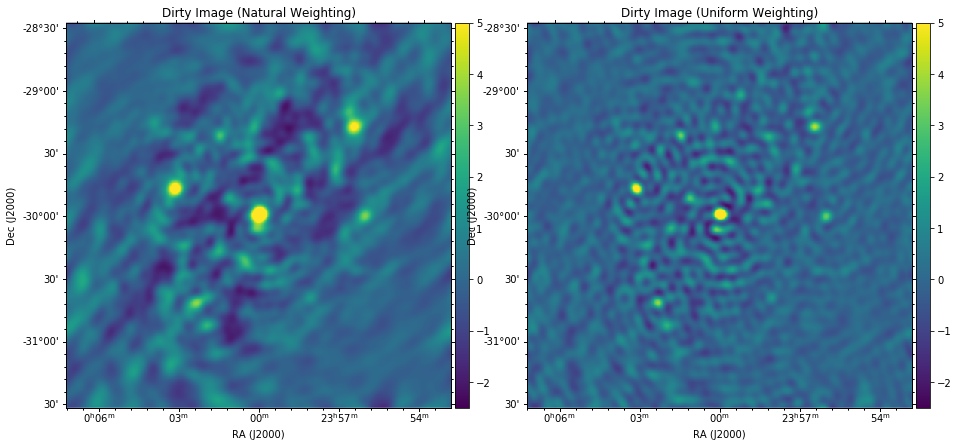

In [13]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_natural-psf.fits', figure=fig, \
                       subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-0.12, vmax=0.4, cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('PSF (Natural Weighting)')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-psf.fits', figure=fig, \
                       subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-0.12, vmax=0.4, cmap='viridis')
#gc2.hide_axis_labels()
#gc2.hide_tick_labels()
plt.title('PSF (Uniform Weighting)')
gc2.add_colorbar()

fig.canvas.draw()

fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_natural-dirty.fits', figure=fig,
                       subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-2.5, vmax=5., cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('Dirty Image (Natural Weighting)')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-dirty.fits', figure=fig,
                       subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(-2.5, vmax=5., cmap='viridis')
#gc2.hide_axis_labels()
#gc2.hide_tick_labels()
plt.title('Dirty Image (Uniform Weighting)')
gc2.add_colorbar()

fig.canvas.draw()

上：自然权重的KAT-7 PSF（左）和统一权重的PSF（右）。

*Top: KAT-7 PSF using natural weighting (left) and uniform weighting (right).*

下：自然权重的脏图（左）和统一权重的脏图（右）。只看得出亮源，暗源隐藏在了PSF的旁瓣噪声里。

*Bottom: dirty image of a simulated field using natural weighting (left) and uniform weighting (right). Only the brighest sources can be seen, many of the weaker sources are hidden in the PSF sidelobe noise.*

自然权重脏图中的源看上去要比统一权重脏图的大，原因在于自然权重的PSF相应更大。统一权重脏图中的源周围有明显的振铃效应，原因在于统一权重PSF响应的类辛格函数性质，导致了比更为圆滑的自然权重PSF响应更负面的PSF旁瓣。

The source in the naturally-weighted image appear to be larger, due to the larger PSF response, compared to the uniformly-weighted image. The uniformly-weighted image has noticable 'ringing' around sources due to the sinc-like nature of the uniformly-weighted PSF response. This results in more negative PSF sidelobes compared to the smoother naturally-weighted PSF response.

Daniel Briggs 在论文 [<cite data-cite='briggs1995high'>High Fidelity Deconvolution of Moderately Resolved Sources</cite> &#10548;](http://www.aoc.nrao.edu/dissertations/dbriggs/)中提出了可调参数的密度权重函数，其基本思想为，自然权重和统一权重仅仅只是一系列可能权重策略（由一个被称为鲁棒性的参数进行调控）中的两种简单方案，这一系列的可能权重策略被称为鲁棒权重，也被称为Briggs权重。鲁棒参数$R$是这样规定的，其正负两极分别对应自然权重和统一权重，$R$为0时，相应的图像分辨率和方差间达成平衡。不同图像生成器的鲁棒权重的实现不一样，但是应当得到相同的结果。

The idea of an adjustable parameter-based density weighting function was introduced Daniel Briggs' thesis [<cite data-cite='briggs1995high'>High Fidelity Deconvolution of Moderately Resolved Sources</cite> &#10548;](http://www.aoc.nrao.edu/dissertations/dbriggs/). The fundamental idea presented in this thesis was that natural and uniform weighting were simply two schemes on a continuum of possible weighting schemes controlled by a single parameter called the robustness. For this reason, this generalized weighting scheme is called robust weighting (it is also often called Briggs' weighting). The robustness parameter $R$ was developed such that at its two extreme values robust weighting approximated natural and uniform weighting and the zero point for $R$ represents an equal balance between resolution and image variance. The exact implementation of robust weighting varies between imagers, but all imagers should produce similar results.

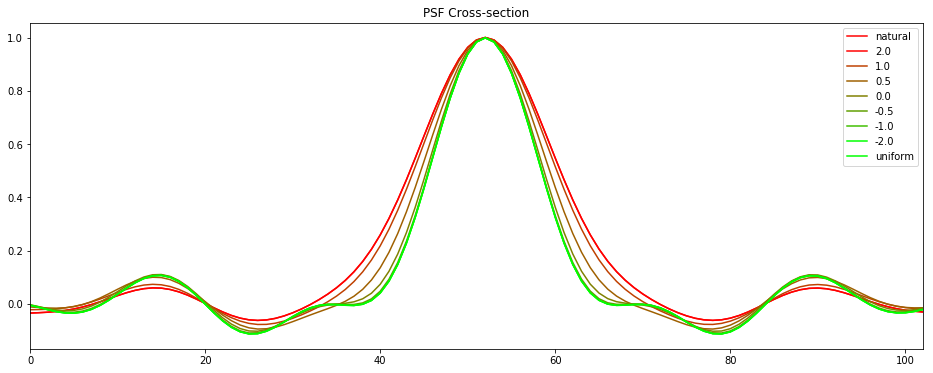

In [16]:
import collections
psfDict = collections.OrderedDict()
psfDict['natural'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_natural-psf.fits'
psfDict['2.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r2.0-psf.fits'
psfDict['1.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r1.0-psf.fits'
psfDict['0.5'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r0.5-psf.fits'
psfDict['0.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r0.0-psf.fits'
psfDict['-0.5'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-0.5-psf.fits'
psfDict['-1.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-1.0-psf.fits'
psfDict['-2.0'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_r-2.0-psf.fits'
psfDict['uniform'] = '../data/fits/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-psf.fits'

fig = plt.figure(figsize=(16, 6))
for key in psfDict:
    fh = fits.open(psfDict[key])
    img = fh[0].data
    psfSlice = img[0,0,int(img.shape[2]/2.)] #take central slice
    subPsfSlice = psfSlice[int(2.*psfSlice.shape[0]/5.):int(3.*psfSlice.shape[0]/5.)] #take inner fifth
    if key=='natural':
        c = [1.0, 0.0, 0.0]
    elif key=='uniform':
        c = [0.0, 1.0, 0.0]
    else:
        norm = (float(key) + 2.)/4.
        c = [norm, 1.0-norm, 0.0]
    plt.plot(subPsfSlice, label=key, color=c)
plt.title('PSF Cross-section')
plt.xlim(0, subPsfSlice.shape[0]-1)
plt.legend()

图：KAT-7的PSF横截面，包括了自然权重（natural）、统一权重（uniform）、以及鲁棒权重（robust）。自然权重（红色）的旁瓣小，主瓣宽；统一权重（绿色）的主瓣窄，旁瓣大；鲁棒权重可以进行参数控制，在主瓣分辨率和旁瓣水平两者间权衡调整。参数为-2的鲁棒权重近似于统一权重，参数为2的鲁棒权重近似于自然权重。

*Figure: Cross-section of the KAT-7 PSF for natural, uniform, and a range of robust weighting functions. Natural weighting (red) results in the smallest absolute amplitude sidelobes but at the price of a wider main lobe. Uniform weighting (green) results in the narrowest main lobe but the cost of larges sidelobes. Robust weighting allows for parameterized control to make a trade off between main lobe resolution and sidelobe levels. Robustness of -2 is approximately the same as uniform weighting, and a robustness of 2 is approximately the same at natural weighting.*

对于一次观测来说，如果被多次采样的可见度比被较少采样的可见度更加受到重视（即自然权重），则该权重函数是鲁棒的。因此，正的鲁棒参数接近自然权重，负的鲁棒参数接近统一权重。

A weighting function is robust if visibility samples which are oversampled during an observation are favoured over the less well-sampled visibilities, i.e. a natural weighting. Thus, a positive robustness parameter results in a weighting similar to the natural weighting, and a negative robustness results in a weighting similar to uniform weighting.

鲁棒参数$R = -2$，鲁棒权重近似于统一权重，$R = 2$，鲁棒权重近似于自然权重，鲁棒权重形式化表示中也允许$|R| > 2$。当$R > 2$，给予最重复采样的可见度（来自短基线）更大的权重，这就导致了比自然权重更低的分辨率和更平滑的旁瓣特性，当我们对大尺度弥散结构更感兴趣的时候，可以设置这样的鲁棒参数。当$R < -2$时，将提升最少采样可见度（长基线）的权重，这导致了比统一权重更高的分辨率和更高的旁瓣特性，当我们要对高信噪比的源成像并希望获得较好分辨率的时候，可以设置成这样的鲁棒参数。


A robust weighting with $R = -2$ results in an approximately uniform weighting, and $R = 2$ results in an approximately natural weighting. The robust weighting formalization also allows for $|R| > 2$. An $R > 2$ overweights the most oversampled visibility (from the shorter baselines), this will result in lower resolution than natural weighting and smoother sidelobe characteristics, this may be useful when one is interested in imaging large, diffuse structure. An $R < -2$ will up-weight the least sampled visibilities (longest baselines) which results in a a higher resolution image than uniform weighting but also with higher sidelobe characteristics. This may be useful if one is imaging a field which has high signal to noise sources and wish to better resolve those sources.

在基线相对均匀分布的情况下（如KAT-7），密度权重函数的选择还不太重要。然而，当对中央密集分布的阵列（如MeerKAT第1版，以及将来的SKA MID）进行成像时，密度权重函数的选择就变得非常重要。对于MeerKAT和SKA MID，大量基线都落在低空间频率区域，因此在这些区域存在过多采样，可以从PSF看到这样做的后果。这个时候，如果选择自然权重，源的周围会产生类似光晕的结构，而统一权重则会显著提高图像的角分辨率。

In the case where baselines are relatively evenly spread out (such as the KAT-7 example above) the choise of density weighting function is not too important. However, when imaging on core-dense arrays such as MeerKAT array release 1, and in the future SKA MID, it plays an important role. In both these cases a large portion of the baselines falls in the low spatial frequency region, thereby effectively over-emphasising measurements taken in that region. You can see the effect this has on the PSF. In these instances choosing natural weighting will create a halo-like structure around sources, whereas uniform weighting will significantly increase angular resolution.

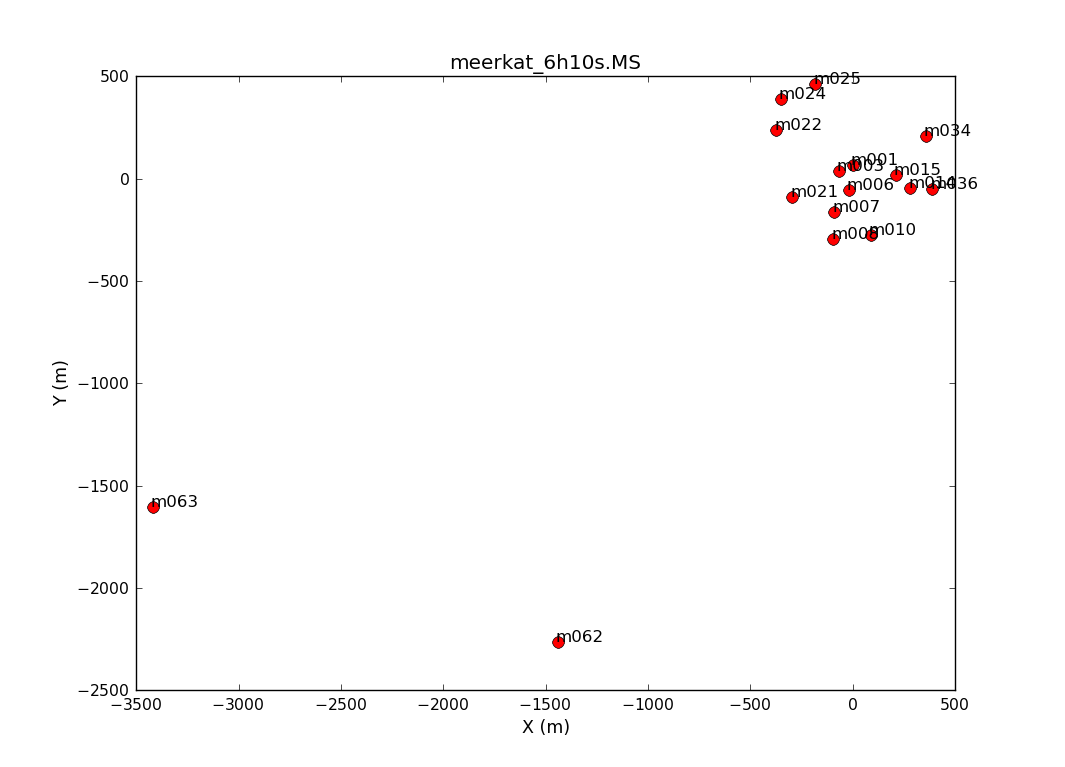

In [17]:
Image(filename="figures/meerkat_AR1.png")

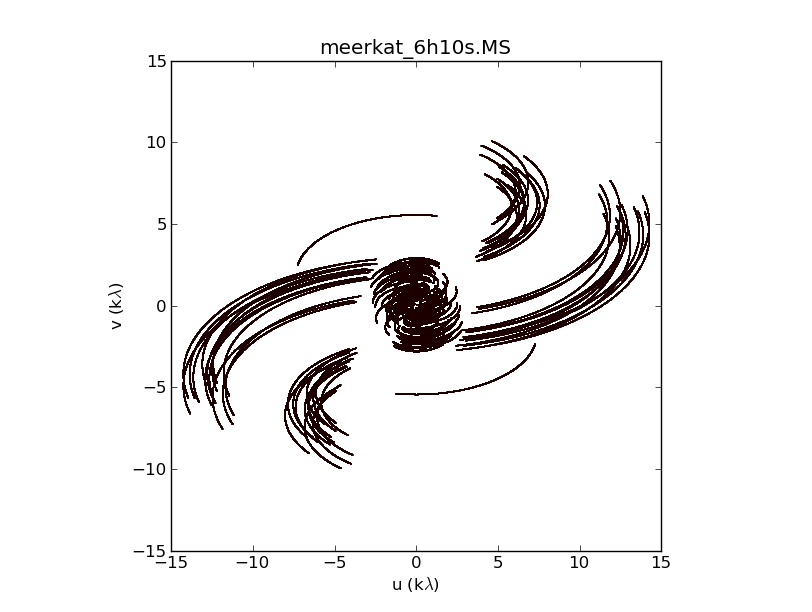

In [18]:
Image(filename="figures/meerkat_16hr_1.1ghz.png")

图：MeerKAT-1阵列的天线布局及其1.1GHz、6小时观测的UV覆盖。相对于JVLA和KAT-7，这是一个中央密集的阵列布局。

*Figure: Antenna positions of MeerKAT array release 1 and its associated UV coverage at 1.1GHz for a 6 hour observation. This configuration is especially core dense compared to, for example, the JVLA and KAT-7*

In [19]:
import collections
psfDict = collections.OrderedDict()
psfDict['2.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs2.0-psf.fits'
psfDict['1.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs1.0-psf.fits'
psfDict['0.5'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs0.5-psf.fits'
psfDict['0.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs0-psf.fits'
psfDict['-0.5'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-0.5-psf.fits'
psfDict['-1.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-1-psf.fits'
psfDict['-2.0'] = '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs-2-psf.fits'

fig = plt.figure(figsize=(16, 6))
for key in psfDict:
    fh = fits.open(psfDict[key])
    img = fh[0].data
    psfSlice = img[0,0,int(img.shape[2]/2.)] #take central slice
    subPsfSlice = psfSlice[int(2.*psfSlice.shape[0]/5.):int(3.*psfSlice.shape[0]/5.)] #take inner fifth
    norm = (float(key) + 2.)/4.
    c = [norm, 1.0-norm, 0.0]
    plt.plot(subPsfSlice, label=key, color=c)
plt.title('PSF Cross-section')
plt.xlim(0, subPsfSlice.shape[0]-1)
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '../data/fits/psfs/meerkat_16_6hr_1.1ghz_briggs2.0-psf.fits'

<Figure size 1152x432 with 0 Axes>

权重策略不只有统一、自然和鲁棒。还有一些针对特定阵列的权重函数，比如针对东-西阵列的径向权重，以及超统一权重（super-uniform）和亚统一权重（sub-uniform），后面两种权重函数可以打破PSF对图像像素分辨率和视场的依赖。成像的时候，像素分辨率和像素数量，即视场，是可以调整的，这就意味着每个像素点的比例会随着这些参数的变化而变化。因此，低分辨率图像的每个像素，会比高分辨率图像的每个像素容纳更多的可见度采样，这就造成了，即便使用的是相同的权重函数，PSF响应也会因像素分辨率以及视场的不同而不同。超统一权重和亚统一权重可以为权重设定一个固定的网格尺寸，该尺寸不依赖于图像分辨率，这样就允许PSF在不同分辨率和视场间达成一致。

Uniform, natrual, and robust are not the only weighting schemes. There are array specific ones such as radial weighting which is used with east-west arrays. And, there is super- and sub-uniform weighting which are used to break the dependence of the PSF to the image pixel resolution and field of view. When imaging the pixel resolution and and number of pixels (field of view imaged) is adjustable. This means that the scale of the a pixel will change depending on these parameters. Thus, a low resolution image will include more visibility samples per pixel compared to a higher resolution image, and result in a different PSF response even when using the same weighting function. Super- and sub-uniform weighting can be used to set a fixed grid size for the weighting which is independent of the image resolution. This allows for PSF consistancy across different image resolutions and fields of view.

### 5.4.3 锥函数 Taper Functions

密度函数的更一般形式是锥函数。两种函数的用途不同，因此表述为不同的函数。密度函数用于在分辨率和灵敏度之间获得平衡，锥函数用于图像平滑滤波器。干涉测量阵列在空间频率进行测量，然而我们通常只对某个范围的测量感兴趣。如果我们已经知道观测目标源的尺度，或者我们不对源做解析，只想最大限度提升源的信噪比，这时候，锥函数就充当了“匹配过滤器”（“mathced filter”）的角色，过滤出感兴趣的信号，就跟数字信号处理的2-d窗函数一样。在一个源的响应已知的情况下，把响应用作锥函数，可以最大程度地提升信噪比。

A more generalized form of the density function is a taper function. These two functions are presented as different functions since they serve different purposes. While the density function is used to balance between resolution and sensitivity, taper functions are used for applying smooth image-domain filters. An interferometric array measures a range of spatial frequency scales, but say we are only interested in measuring a particular range of those scales. Say we know the size scale of a source that is being observed, or that we do not care about resolving a source but rather maximizing the signal to noise of that source. A taper function acts as a 'matched filter' for a specific signal of interested and is the same as 2-D window functions used in digital signal processing. If the response for a source is known then the signal to noise can be maximized by using the same response as a taper function. [Appendix A &#10142;](5_A_matched_filter.ipynb) of this chapter discusses the use of matched filters in aperture synthesis.

尽管锥函数可以是任意的2-d函数，但实际上一般都选择平滑函数。通常使用2-D高斯，因为高斯函数的傅立叶变换依然是高斯函数（振幅比例不同，所以需要做归一化处理）。上 [Wikipedia:Window Functions &#10548;](https://en.wikipedia.org/wiki/Window_function)，可以参考其它锥函数。

Though the taper function can be any 2-D function, in practice it is usually chosen to be smooth. Commonly a 2-D Gaussian is used as this allows for a set image-domain scale to be converted to a visibility-domain scale, as the Fourier transform of a Gaussian is also a Gaussian (the amplitude scale factors will be different requiring normalization). See [Wikipedia:Window Functions &#10548;](https://en.wikipedia.org/wiki/Window_function) for details on other taper functions.

用径向的高斯全宽半高$\theta_{\text{FWHM}}$设置图像的敏感域尺度，即用一个2-d高斯对图像进行卷积。

The scale of interest in an image can be set the full-width half-maximum of a Gaussian $\theta_{\text{FWHM}}$ in radians. That is, we would like to convolve the image with a 2-D Gaussian

$$ \text{Gauss}(l,m\, | \, \sigma_{I}) = e^{\frac{-(l^2 + m^2)}{2\sigma_{I}^2}}$$

$\sigma_{I}$ 是函数各径向标准差（假定是一个径向对称高斯），$\theta_{\text{FWHM}} = 2 \sqrt{2 \ln{2}}\sigma_{I}$。这是锥响应函数，跟锥函数构成傅立叶对。通过$\sigma_{uv} = \frac{1}{2\pi\sigma_{I}}$在uv域高斯锥函数跟锥函数响应之间建立联系，这里$\sigma_{uv}$以波长数为单位。未经归一化的高斯锥函数为：

where $\sigma_{I}$ is the standard deviation of the function in radians (we are assuming we want a radially symetric Gaussian), and $\theta_{\text{FWHM}} = 2 \sqrt{2 \ln{2}}\sigma_{I}$. This is the taper response function, which is the Fourier pair to the taper function. The uv-domain Gaussian taper function scale can be related to the taper response function with $\sigma_{uv} = \frac{1}{2\pi\sigma_{I}}$ where $\sigma_{uv}$ is in unit number of wavelengths. The resulting (unnormalized) Gaussian taper function is

$$ \text{Gauss}(u,v\, | \, \sigma_{uv}) = e^{\frac{-(u^2 + v^2)}{2\sigma_{uv}^2}} = e^{\frac{-(u^2 + v^2) \pi^2 \theta_{\text{FWHM}}^2}{2 \ln{2}}}$$

Text(0.5,1,'Taper Function (uv domain)')

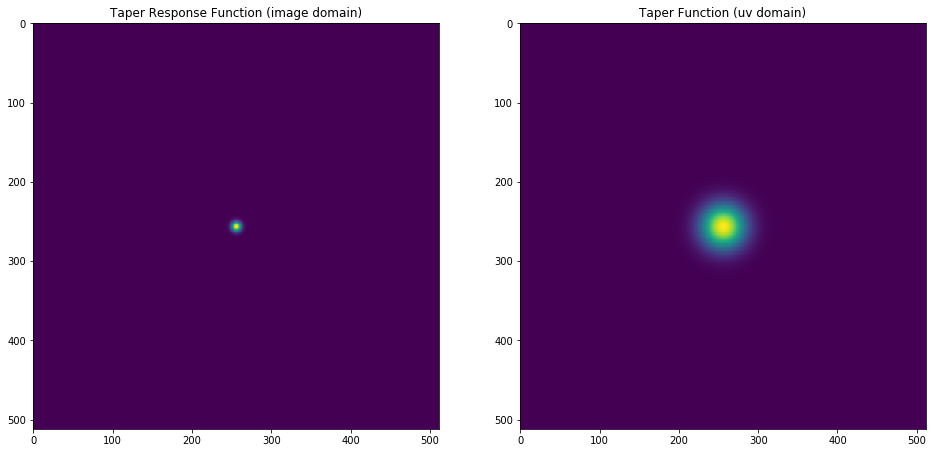

In [20]:
def gaussianTaperResponse(imSize, fwhmTheta):
    #Create an image-domain Gaussian taper response
    #imSize: [int, int] image size
    #fwhmTheta: full-width half-maximum in pixels
    lpos, mpos = np.mgrid[0:imSize[0],0:imSize[1]]
    sigma = fwhmTheta / (2. * np.sqrt(2. * np.log(2)))
    taper = np.exp(-1. * (((lpos - (imSize[0]/2.))**2. + (mpos - (imSize[1]/2.))**2.) / (2. * sigma**2.)))
    return taper

fig = plt.figure(figsize=(16, 8))

plt.subplot(121)
taperResponse = gaussianTaperResponse([512, 512], 10)
plt.imshow(taperResponse, cmap='viridis')
plt.title('Taper Response Function (image domain)')

plt.subplot(122)
taperedFunc = np.abs(np.fft.fftshift(np.fft.fft2(taperResponse)))
plt.imshow(taperedFunc, cmap='viridis')
plt.title('Taper Function (uv domain)')

图：图像域的高斯锥响应函数与uv域的锥函数组成傅立叶对。

*Figure: image-domain Gaussian taper response function and the Fourier paired uv-domain taper function.*

高斯锥函数类似于图像处理中的平滑过滤器，同样，锐化过滤器也可以用作锥函数，用来过滤紧凑目标，如点源。

A Gaussian taper function is equivalent to a smoothing filter used in image processing. Similarly, a sharpen filter could be used as a taper function to filter for compact object such as point sources.

Text(0.5,1,'Dirty Image (40 pixel taper)')

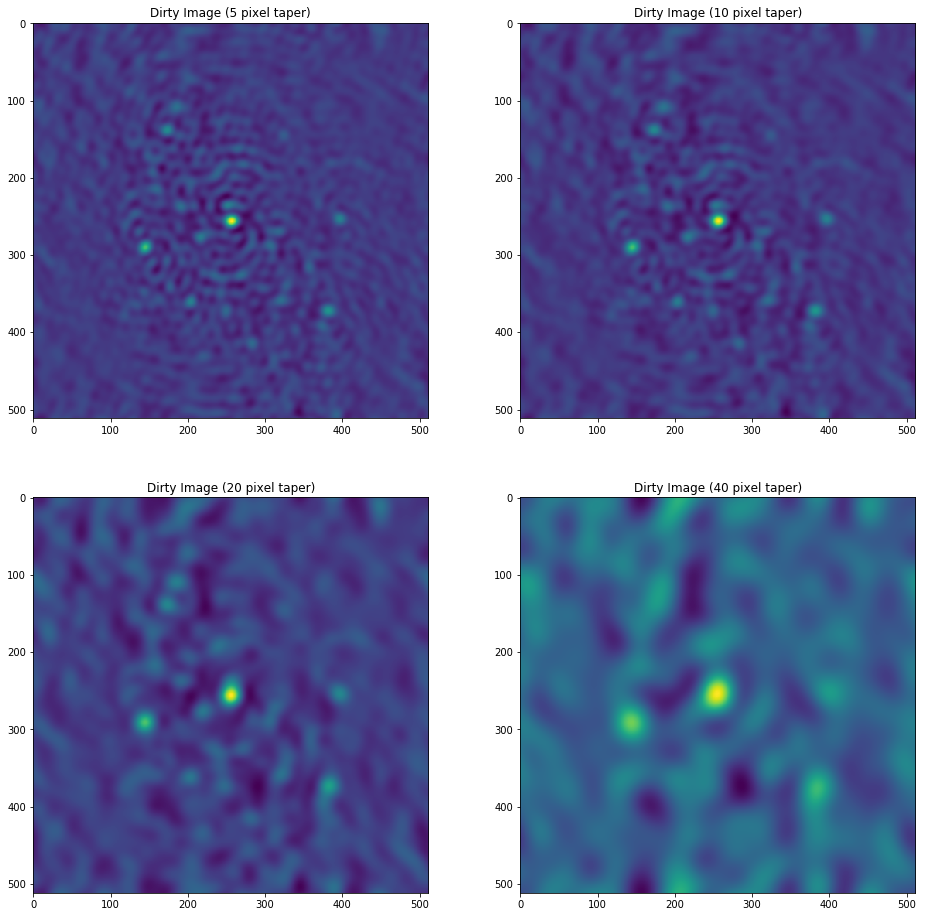

In [21]:
def convolveTaper(taperResponse, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(taperResponse) * np.fft.fft2(img))).real
    
fh = fits.open('../data/fits/dirty/KAT-7_6h60s_dec-30_10MHz_10chans_uniform-dirty.fits')
img = fh[0].data[0,0]

fig = plt.figure(figsize=(16, 16))

plt.subplot(221)
taperResponse = gaussianTaperResponse(img.shape, 5)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (5 pixel taper)')

plt.subplot(222)
taperResponse = gaussianTaperResponse(img.shape, 10)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (10 pixel taper)')

plt.subplot(223)
taperResponse = gaussianTaperResponse(img.shape, 20)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (20 pixel taper)')

plt.subplot(224)
taperResponse = gaussianTaperResponse(img.shape, 40)
taperedImg = convolveTaper(taperResponse, img)
plt.imshow(taperedImg, cmap='viridis')
plt.title('Dirty Image (40 pixel taper)')

图：应用不同尺度（从左上按顺时针方向：5、10、20、40像素）的锥所获得的KAT-7脏图。

*Figure: KAT-7 dirty image (uniform weighting) with different scale tapers applied (from top left clockwise: 5, 10, 20, 40 pixels).*

上图中的原始脏图分辨率约为5像素，当卷积一个5像素的高斯锥函数，看不出明显变化（左上图）。但是，随着锥尺寸的增长，分辨率随着下降，因为相比于高频部分，低频部分提高了权重。

In the figures above the the resolution of the original dirty image was approximately 5 pixels, when a 5 pixel Gaussian taper function is applied (top left) there is no noticable effect on the image. But, as the taper size is increased the resolution is reduced as the lower spatial modes are upweighted compared to the higher spatial modes.

具有大量且随机布局的天线阵列，能获得较好的跟高斯分布近似的采样效果。在成图的时候，使用统一权重加上可见度高斯分布的锥函数，能产生跟不带锥函数的自然权重相同的效果。

A randomly distributed array with a significant number of elements will result in an well-sampled, approximately Gaussian visibility sampling distribution. Using a uniform weighting with a taper function on the scale of the the Gaussian distribution of the visibilities will produce the same effective image as using natural weighting with no taper function.

### 5.4.4 测量可靠性函数 Measurment Reliability Function

权重函数的最后一个部分是测量可靠性函数$R(u,v)$，该函数跟天线阵列和观测本身密切相关。一次观测过程中，如果用到的所有组件都一样，则每个可见度测量的相对可靠性也一样。然而，如果阵列中某个组件的系统温度较高（噪声）或者组件的天线较小（灵敏度较低），则将给跟该组件有关的任何基线的测量带来较大的噪声，应当加以权重。包括天线有效收集面积以及系统温度在内的这些先验知识，要体现在可靠性函数里，另外，观测过程中每个组件的性能变化也要包括在函数里。例如VLBI，每个望远镜的灵敏度不同，需要把这点考虑进去。如果原始观测过程中，不需要考虑可靠性权重，则可以把该函数的每个值都置为1。

The last component of the weighting function is the measurement reliability function $R(u,v)$. This function is intrinsic to an array and observation. If an observation is made with an array of identical elements then the relative reliability of each visibility measurement would be the same. But, say one element of an array has a higher system temperature (i.e. it is noisier) or the element has a smaller dish (less sensitive) then any baseline correlation which includes this element will result in a noisier measurment and should be weighted as such. A priori information, such as an elements effective collection area or expected system temperature, can be included in this function. Variability in the performance of individual elements during an observation is also included in this function. For example, if one of the telescopes has a noisy amplifier which needs to be fixed compared to the other telecsopes in the array. For mixed arrays such as with VLBI each individual telescope will have a different sensitivity which needs to factored in. If no relibabilty weights are included in the original observation then this function is set to unity and ignored.

### 5.4.5 脏图的局限性 Limits of the Dirty Image

脏图上可以看到，在源的周围存在类似PSF的旁瓣，我们知道这实际上只是可见度采样（仪器测量本身）所产生的效果，并不是真实天空。由此我们要问，这些旁瓣能去除吗？如果能去除，会得到什么样结果？对于第二个问题，如果能去除源周围的大的旁瓣，就能发现其它被隐藏在下面的暗弱源，也就是降低了图像的噪声水平，或者说，去除旁瓣能提升图像的动态范围。对于第一个问题，我们的答案是可以通过去卷积的方法，在一定程度上去除测量本身所造成的结构。

From the dirty images presented earlier in this section we can see that around the sources there are PSF-like sidelobes, but we know that this is an effect of the visibility sampling (our measurement instrument) and not the part of the true sky. So we can then ask, can we remove these sidelobes? And, what is the effect if we can? The answer to the second question is that if we can remove some of the larger sidelobes then we should be able to find other weaker sources in the field that could be hidden below, i.e. the noise floor of the image would be lower. We would say that the dynamic range increases if those sidelobes can be removed. The answer to the first question is that we can remove the structure imposed by the measurement to an extent by the use of deconvolution methods.

综合成像技术发展之初，特别是在引入CLEAN方法去卷积以后，开始使用“脏图”这一术语。CLEAN用于从观测可见度“更好”地复原图像，“更好”是个主观且没有被明确定义的概念，然而，可以确定的是，脏图中的亮源被类似PSF的旁瓣所包围，而这些旁瓣是由不规则采样造成的。假定天空是平滑且连续的，可以推理出可见度也应该平滑且连续。就算只对可见度进行了部分采样，我们也可以基于上述假设，采取适当的方法，增强图像的平滑性，这就得到了被卷积掉PSF的“洁图”。下一章将对此进行详细讨论。

The term 'dirty image' came about after the initial development of synthesis imaging, the term was introduced when deconovlution methods, in particular the CLEAN method, were introduced to recover a 'better' image from the observed visibilities. The concept of better is subjective and not well-defined. But, the main idea is that a dirty image contains bright sources which are surrounded by PSF-like sidelobes due to the irregular visibility sampling. By making the assumption that the sky should be smooth and continuous then we can also assume the visibilities are smooth and continuous. Even though we are only sampling a portion of the visibilities we can use this assumption to enforce a smoothness which results in a 'clean' image in which the PSF has been deconvolved. This will be discussed in detail in the next chapter.

在介绍去卷积之前，我们先讨论有关大视场成像的问题。在本节的开头，我们给了一个方程，该方程把脏图跟测量可见度联系了起来。然而这只是一个近似方程，为了把方程简化成二维，忽略了w项。该方程适用于窄视场，然而我们通常对覆盖大面积的大视场成像更感兴趣。对于大视场成像，w项必须考虑进去。有一系列技术常规技术，对可见度和图像之间的简单2-d傅立叶变换进行小调整，以补偿缺失的w项。下一节将介绍这方面的内容。

But, before we introduce deconvolution we will finish the chapter on the issue of imaging large field of views. At the start of this section we presented an equation which relates the dirty image to the measured visibilities, but this is an approximate equation. The w-term has been ignored to reduce the equation down to a 2-D Fourier transform. This equation holds well for a narrow field of view, but we are often interested in imaging larger fields of view with arrays spread over large areas. In order to do this the w-term must be included. A number of techniques are routinely used to effectively include preturbations to the simple 2-D Fourier relation between visibilities and the image to compensate for the missing w-term. This is that topic that will be covered in the next section.

***

Next: [5.5 The Break Down of the Small Angle Approximation and the W-Term](5_5_widefield_effect.ipynb)